# Automating Data Quality Validation Data 70-80% By Month
## Author: David Schanzer
## Student ID: 82329622
### Subject: 32933 Research Project
### Session: Spring 2023
### Assessment 1: Prototype Research
### Supervisor: Dr Amara Atif
### This Jupyter Notebook trains a Novelty Detection machine learning model for a chosen algorithm using the specified monthly, fortnightly or weekly "clean" files as its Training Set. It then tests the predictive accuracy of this model using randomly selected "clean" or "dirty" files from its Testing Set using ROC AUC as its accuracy metric. It also produces Analytics files to measure each Test file column's deviation from the previously received file, and Explanation files that summarise the reasons for each rejected file being considered suspect.

In [2]:
import warnings
warnings.filterwarnings('ignore')

from collections import namedtuple, Counter as count
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from hyperloglog import HyperLogLog
from pyod.models.knn import KNN
from sklearn.metrics import confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from abc import abstractmethod
from nltk.util import ngrams
from pathlib import Path
from enum import IntEnum
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import pytz
from datetime import datetime
from math import log10, floor
from tqdm.notebook import trange
import os

In [3]:
# Round to n significant digits
def round_to_n(x, n):
    if x == 0:
        value = 0
    else:
        value = round(x, -int(floor(log10(abs(x)))) + (n - 1))
        
    return value

In [4]:
def float_converter(num):
    try:
        return np.float(num)
    except:
        return np.nan

In [5]:
def rmtree(f: Path):
    if f.is_file():
        f.unlink()
    else:
        for child in f.iterdir():
            rmtree(child)
        f.rmdir()

In [6]:
def create_folder(baseFolder, folderName):
    folderPath = baseFolder + folderName
    folderPathObj = Path(folderPath)
    # If folder already exists
    if folderPathObj.exists():
        # then recursively delete all files and folders
        rmtree(folderPathObj)

    # Sleep for 1 second to allow the file system to register the folder deletion
    time.sleep(1)
    
    # Create a new empty folder
    folderPathObj.mkdir()

In [7]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print('%r took %2.2f ms' % (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [8]:
class Quality(IntEnum):
    GOOD = 0
    BAD = 1

In [9]:
class Learner:
    @abstractmethod
    def fit(history):
        pass

    @abstractmethod
    def predict(X):
        pass
    
    @abstractmethod
    def predict_proba(X):
        pass
    
    @abstractmethod
    def decision_function(X):
        pass

In [10]:
class KNNLearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn
        self.classifier = None

    def fit(self, history, contamination):
        learner = KNN(contamination = contamination,
                      n_neighbors = 5,
                      method = 'mean',
                      metric = 'euclidean',
                      algorithm = 'ball_tree')

        # Convert list to dataframe temporarily
        df_history = pd.DataFrame(history)

        # Replace any NaN values with the mean for that column
        df_history.fillna(df_history.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_history.mean() itself returns NaN)
        df_history.fillna(0, inplace=True)

        # Convert dataframe back to list
        history = df_history.values.tolist()                 
        
        self.classifier = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        # get the prediction labels and outlier scores of the training data -  binary labels (0: inliers, 1: outliers)
        y_all_predictions = learner.labels_      

        # get raw outlier scores
        y_all_scores = learner.decision_scores_  
        
        # get threshold score
        threshold = learner.threshold_

        return threshold

    def predict(self, X_test):
        assert self.classifier is not None, '.fit first'

        # Convert list to dataframe temporarily
        df_X_test = pd.DataFrame(X_test)

        # Replace any NaN values with the mean for that column
        df_X_test.fillna(df_X_test.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_history.mean() itself returns NaN)
        df_X_test.fillna(0, inplace=True)

        # Convert dataframe back to list
        X_test = df_X_test.values.tolist()                 
        
        # get the prediction on the test data - outlier labels (0=not outlier or 1=outlier)
        y_test_pred = self.classifier.predict(X_test)
        
        # get outlier scores
        y_test_scores = self.classifier.decision_function(X_test)  
        
        return y_test_pred, y_test_scores
    
    def predict_proba(self, X):
        assert self.classifier is not None, '.fit first'
            
        outlier_probability = self.classifier.predict_proba(X, method='linear', return_confidence=False)
        return outlier_probability

In [11]:
class DataProfiler:
    class __DP:
        def __init__(self):
            self.analyzer = {
                'Completeness': lambda x, dtype: self.completeness(x, dtype),
                'Uniqueness': lambda x, dtype: self.uniqueness(x, dtype),
                'ApproxCountDistinct': lambda x, dtype: self.approx_count_distinct(x, dtype),
                'ModeRatio': lambda x, dtype: self.mode_ratio(x, dtype),
                'Mean': lambda x, dtype: self.mean(x, dtype),
                'Minimum': lambda x, dtype: self.minimum(x, dtype),
                'Maximum': lambda x, dtype: self.maximum(x, dtype),
                'StandardDeviation': lambda x, dtype: self.standard_deviation(x, dtype),
                'PeculiarityIndex': lambda x, dtype: self.peculiarity(x, dtype),
            }

            self.dtype_checking = {
                'int64': True,
                'float64': True
            }

        def completeness(self, x, dtype):
            completeness = 1. - np.sum(pd.isna(x)) / x.shape[0]

            return completeness

        def uniqueness(self, x, dtype):
            tmp = [i for i in count(x).values() if i == 1]
            uniqueness = 1. * np.sum(tmp) / pd.notna(x).shape[0]
                
            return uniqueness

        # def count_distinct(self, x):
        #     return 1. * len(count(x).keys()) / pd.notna(x).shape[0]

        def approx_count_distinct(self, x, dtype):
            hll = HyperLogLog(.01)
            for idx, val in x.items():
                hll.add(str(val))

            approx_count_distinct = len(hll)
            
            return approx_count_distinct

        def mode_ratio(self, x, dtype):
            # Calculate the number of rows with the mode (most frequent) value as a proportion of the non-NaN rows
            mode_ratio = 1. * max(count(x).values()) / pd.notna(x).shape[0]
                
            return mode_ratio

        def mean(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            mean = pd.to_numeric(x, errors='coerce').mean()   
                
            return mean

        def minimum(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            min = pd.to_numeric(x, errors='coerce').min()   
                
            return min

        def maximum(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            max = pd.to_numeric(x, errors='coerce').max()   
                
            return max 

        def standard_deviation(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            sd = pd.to_numeric(x, errors='coerce').std()   
                
            return sd 

        def peculiarity(self, x, dtype):
            # Index of peculiarity is based on the bi- and trigram tables of a textual attribute and reflects the
            # likelihood of the hypothesis that trigrams in a given word are produced from the same data source
            # that produced the trigram table. This index is originally applied for detection of typographical
            # errors and facilitates detection of typos in text or a “peculiar” occurrence of symbols in words.
            def _peculiarity_index(word, count2grams, count3grams):
                t = []
                for xyz in ngrams(str(word), 3):
                    xy, yz = xyz[:2], xyz[1:]
                    cxy, cyz = count2grams.get(xy, 0), count2grams.get(yz, 0)
                    cxyz = count3grams.get(xyz, 0)
                    t.append(.5* (np.log(cxy) + np.log(cyz) - np.log(cxyz)))

                return np.sqrt(np.mean(np.array(t)**2))

            aggregated_string = ' '.join(map(str, x))
            c2gr = count(ngrams(aggregated_string, 2))
            c3gr = count(ngrams(aggregated_string, 3))

            peculiarityIndex = x.apply(lambda y: _peculiarity_index(y, c2gr, c3gr)).max()
                
            return peculiarityIndex

    instance = None

    def __init__(self):
        if not DataProfiler.instance:
            DataProfiler.instance = DataProfiler.__DP()

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def _compute_for_column(self, column, dtype, *analyzers):
        return [self.instance.analyzer[name](column, dtype) for name in analyzers]

    # @timeit
    def compute_for(self, batch, return_labels=False):
        profile, labels = [], []
        generic_metrics = ['Completeness', 'Uniqueness', 'ApproxCountDistinct', 'ModeRatio']
        numeric_metrics = ['Mean', 'Minimum', 'Maximum', 'StandardDeviation']
        dtypeList = []
        
        for col, dtype in zip(batch.columns, batch.dtypes):
            # For every column, compute generic metrics,
            # add additional numeric metrics for numeric columns
            metrics = copy.deepcopy(generic_metrics)
            
            if self.dtype_checking.get(str(dtype), False):
                metrics.extend(numeric_metrics)
                
            # Dummy check for likely-to-be-strings
            if dtype == 'object': 
                metrics.append('PeculiarityIndex')
                
            dtypeList.append(dtype)
            column_profile = self._compute_for_column(batch[col], dtype, *metrics)
            profile.extend(column_profile)
            labels.extend([f'{col}_{m}' for m in metrics])

        return profile if not return_labels else (profile, labels)

In [12]:
class DataQualityValidator:
    def __init__(self):
        self.clf = KNNLearner()
        self.history = []

    def add(self, batch):
        # Replace any infinite values in the batch with a very large valid float64 value
        batch = [1.0e+100 if element == np.inf else element for element in batch]

        self.history.append(batch)
        
        return self

    def test(self, batch, contamination):
        # re-fit the model from scratch
        threshold = self.clf.fit(self.history, contamination)

        # Replace any infinite values in the batch with a very large valid float64 value
        batch = [1.0e+100 if element == np.inf else element for element in batch]   

        # batch (the metrics for the test file) may contain NaN values (eg. for the mean for a numeric column if all values
        # are NaN), so use the mean of the train value instead
        nan_elements = np.where(np.isnan(batch))
        for i in nan_elements[0]:
            np_history = np.array(self.history)
            # Calculate the mean of the column, ignoring NaN values
            history_mean = np.nanmean(np_history[:, i])   
            batch[i] = history_mean

        # Reshape to 2D numpy array because it contains a single sample
        batch = np.array(batch).reshape(1, -1)                                    
        
        # Get the prediction on the test data - returns outlier labels (0 or 1)
        y_test_pred, y_test_scores = self.clf.predict(batch)                      

        outlier_probability = self.clf.predict_proba(batch)

        return (Quality.GOOD if int(y_test_pred) == 0 else Quality.BAD, y_test_pred, y_test_scores, outlier_probability, 
                threshold)

In [13]:
Batch = namedtuple('Batch', 'id clean dirty')

In [14]:
def get_batch_filepaths(clean_name, dirty_name):
    batches = []
    
    df_clean_files = pd.DataFrame(sorted(os.listdir(clean_name)))
    df_dirty_files = pd.DataFrame(sorted(os.listdir(dirty_name)))
    df_clean_files = clean_name + '/' + df_clean_files
    df_dirty_files = dirty_name + '/' + df_dirty_files

    # Concatenate the index position with the clean and dirty files into a single dataframe
    df_concat = pd.concat([pd.DataFrame(df_clean_files.index.values + 1), df_clean_files, df_dirty_files], axis = 1)
    df_concat.columns = ['id', 'clean', 'dirty']

    batches = df_concat.values.tolist()
    n_batches = len(batches)
    
    return batches, n_batches

In [15]:
def good_or_bad(batch):
    return np.random.choice([Quality.GOOD, Quality.BAD], p=[5./10, 5./10])

In [16]:
def determine_major_differences(profile, labels, result, df_cumulative_means, filepath, analysis_path, explanations_path,
                                print_explanations):
    explanation_guidance_accurate = ''
    
    # Convert profile series to dataframe 1
    df_profile = pd.DataFrame(profile, index = labels)

    # Subtract means from this profile to dataframe 2
    df_difference = df_profile.subtract(df_cumulative_means, axis = 'index')

    # Compute absolute percentage differences to dataframe 3
    df_percent_change = df_difference.div(df_cumulative_means).abs() * 100

    # Add column name on dataframe 3
    df_percent_change.columns = ['PercentChange']

    # Replace any infinite values with NaN on dataframe 3
    df_percent_change = df_percent_change.replace(np.inf, np.nan)

    # Now concatenate the 3 dataframes into a single dataframe
    df_concat = pd.concat([df_profile, df_cumulative_means, df_percent_change], axis = 1)

    # Add column names
    df_concat.columns = ['TestProfile', 'CumulativeProfileMeans', 'PercentChange']

    # Sort descending, with NaN values at the end
    df_concat = df_concat.sort_values(by = ['PercentChange'], ascending = False, na_position = 'last')

    # Save analysis file
    analysis_folder = analysis_path + '/'
    filename = filepath.split('/')[-1]
    filename_no_file_extension = filename[0:-4]
    #df_concat.to_csv(analysis_folder + result + '_' + str(filename_no_file_extension) + '_analysis.csv')

    # If the result was 'TP' (true positive) or 'FP' (false positive)
    if result[1] == 'P':
        # Open an explanation text file for writing
        explanations_folder = explanations_path + '/'
        #explanations_file_object = open(explanations_folder + result + '_' + str(filename_no_file_extension)
        #                                + '_explanation.txt', 'w')
        
        # Prepare the human-readable rejection reasons.
        # Firstly, reset index so that we can rename the unnamed column as Column_Measure, as this is the current index.
        df_concat.reset_index(names=['Column_Measure'], inplace = True)

        # Split this combined Column_Measure column on underscore into separate Column and Measure columns
        column_measures = df_concat['Column_Measure'].str.split(pat = '_', expand = True)

        # Add the Column column in position 1
        df_concat.insert(loc = 1, column = 'Column', value = column_measures[0])

        # Add the Measure column in position 2
        df_concat.insert(loc = 2, column = 'Measure', value = column_measures[1])

        # Drop the Column_Measure column
        df_concat.drop(['Column_Measure'], axis=1, inplace = True)

        # Filter out any rows where the percentage change is less than 1%, since this the smallest percentage of
        # synthetic errors inserted into any "dirty" file.
        df_concat.query('PercentChange >= 1', inplace = True)

        # Group by Column name
        by_column = df_concat.groupby('Column', sort = False)

        # Split the filepath by underscores into a list to extract the column names with synthetic errors
        # filepath is assumed to be in one of these formats:
        # Clean files:
        # <desc>_<clean>_<fileno>_<year>_<month>.csv
        # Dirty files:
        # <desc>_<clean-or-dirty>_<fileno>_<year>_<month>_<pct%>_error_<error-number>_in_columns_<column-1>_and_<column-2>.csv
        # or just (for errors that affect only one column):
        # <desc>_<clean-or-dirty>_<fileno>_<year>_<month>_<pct%>_error_<error-number>_in_column_<column-1>.csv
        error_columns = []
        # Remove last 4 chars as these are assumed to be '.csv'
        filepath_components = filepath[0:-4].split('_')
        clean_dirty = filepath_components[1]
        if clean_dirty == 'dirty':
            # Add 11th element, which is the value 'column-1' in the example above.
            error_columns.append(filepath_components[10])

            # Extract 10th element, which is the value 'columns' or 'column' in the example above.
            column_word = filepath_components[9]

            if column_word == 'columns':
                error_columns.append(filepath_components[12])

        explanation_columns = []
        i = 1
        
        if print_explanations == 'y':
            print("Rejection explanation:")
            
        for column, frame in by_column:
            # Add this column to the list of columns that appear in the explanation
            explanation_columns.append(column)
            print_string = str(i) + ': Column "' + column + '"'
            #print(print_string, file = explanations_file_object)
            
            if print_explanations == 'y':
                print('    ' + print_string)
            
            for index, row in frame.iterrows():
                print_string1 = '    ' + row['Measure'] + ' is ' + str(int(row['PercentChange'])) + '%'
                print_string2 = 'lower' if row['TestProfile'] < row['CumulativeProfileMeans'] else 'higher'
                print_string3 = '(' + str(round_to_n(row['TestProfile'], 5)) + ') than previous file'
                print_string4 = '(' + str(round_to_n(row['CumulativeProfileMeans'], 5)) + ')'
                #print(print_string1, print_string2, print_string3, print_string4, file = explanations_file_object)
                
                if print_explanations == 'y':
                    print('   ', print_string1, print_string2, print_string3, print_string4)
            i += 1

        # Test if all error columns appeared in the explained columns - this is the definition of accurate guidance
        if len(explanation_columns) > 0 and len(error_columns) > 0:
            if all(item in explanation_columns for item in error_columns):
                print_string = 'Explanation guidance was accurate'
                #print(print_string, file = explanations_file_object)
                
                if print_explanations == 'y':
                    print(print_string)
                    
                explanation_guidance_accurate = 'y'
            else:
                print_string = 'Explanation guidance was NOT accurate'
                #print(print_string, file = explanations_file_object)
                
                if print_explanations == 'y':
                    print(print_string)
                    
                explanation_guidance_accurate = 'n'

        # Close the explanation text file
        #explanations_file_object.close()
    
    if print_explanations == 'y':
        print()
    
    return explanation_guidance_accurate

In [17]:
def train_test(n_batches, n_train, batches_iter, contamination, analysis_path, explanations_path):
    clf_name = 'KNN'
    print_explanations = 'n'
    
    # Seed the random number generator to the same value each time so that we get consistent choices and ROC AUC
    np.random.seed(42)

    # Calculate number of testing files
    n_test = n_batches - n_train

    dqv = DataQualityValidator()

    # Training phase
    #print('Training phase: calculating metrics on ' + str(n_train) + ' good files')

    # All training files are designated as 'good'
    y_train = np.zeros(n_train)

    cumulative_profiles = []
    row_counts = []
    converters = {}

    for day in trange(n_train, desc = f'Training the model on {n_train} files'):
        batch_list = next(batches_iter)
        
        # Convert list to named tuple
        batch = Batch(batch_list[0], batch_list[1], batch_list[2])

        # Take the dtypes from the first training batch, and use this as the dtype for all subsequent training and testing
        # batches.
        if day == 0:
            # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2, which uses
            # the string 'NONE' to indicate unknown, is read as a NaN value.
            batch_data = pd.read_csv(batch.clean, sep=',', low_memory = False, na_values = ['NULL', 'NONE', 'MISSING'],
                                     keep_default_na = False)

            # Get list of all columns that have only NaN values in the first training file
            nan_cols = [i for i in batch_data.columns if batch_data[i].isnull().all()]

            stored_dtypes = batch_data.dtypes.to_dict()

            # Make some changes to the datatypes that were derived from the first training file
            for key, value in stored_dtypes.items():
                # The Python integer datatype doesn't allow NaN values, so convert all int64 to float64 (which does allow
                # NaNs).
                if value == 'int64':
                    stored_dtypes[key] = 'float64'
                    value = stored_dtypes[key]

                # If all rows have a NaN value, then the datatype ends up as float64, which would result in the addition of
                # the numeric metrics, so change this datatype to Object.
                if key in nan_cols:
                    stored_dtypes[key] = 'object'
                    value = stored_dtypes[key]

                # If this is a float64, add the column to the 'converters' dictionary, so that non-numeric values are
                # replaced with NaN during subsequent read_csv calls.
                if value == 'float64':
                    converters[key] = float_converter

            # Convert the datatypes for the first file to these new datatypes
            batch_data = batch_data.astype(stored_dtypes)
        else:
            # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2, which uses
            # the string 'NONE' to indicate unknown, is read as a NaN value.
            batch_data = pd.read_csv(batch.clean, sep=',', dtype = stored_dtypes, low_memory = False,
                                     na_values = ['NULL', 'NONE', 'MISSING'], keep_default_na = False,
                                     converters = converters)

        row_counts.append(len(batch_data))

        profile, labels = DataProfiler().compute_for(batch_data, return_labels = True)

        # Add this training profile to the list
        cumulative_profiles.append(profile)
        dqv.add(profile)

    # Convert the list to a dataframe
    df_cumulative_profiles = pd.DataFrame(cumulative_profiles)

    # Add the column headings to the dataframe
    df_cumulative_profiles.columns = labels

    # Compute the means for each column over the last 12 periods
    #df_cumulative_means = pd.DataFrame(df_cumulative_profiles.mean())
    df_cumulative_means = pd.DataFrame(df_cumulative_profiles.iloc[-1:].mean())

    # Training batches
    X_train = copy.deepcopy(dqv.history)
    row = len(X_train)
    column = len(X_train[0])

    # Testing phase
    #print('Testing phase: Testing ' + str(n_test) + ' files')
    y_test = []
    y_test_predictions = []
    y_test_scores_cumulative = []
    y_outlier_probability_cumulative = []
    explanation_guidance_accuracy_numerator = 0
    explanation_guidance_accuracy_denominator = 0

    for day in trange(n_test, desc = f'Testing the model on {n_test} files'):
        batch_list = next(batches_iter)
        
        # Convert list to named tuple
        batch = Batch(batch_list[0], batch_list[1], batch_list[2])

        reality = good_or_bad(batch)

        if reality == Quality.GOOD:
            # Select a clean file
            filepath = batch.clean
            y_test.append(0)
        else:
            # Select a dirty file
            filepath = batch.dirty
            y_test.append(1)

        # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2, which uses the
        # string 'NONE' to indicate unknown, is read as a NaN value.
        batch_data = pd.read_csv(filepath, sep=',', dtype = stored_dtypes, low_memory = False,
                                 na_values = ['NULL', 'NONE', 'MISSING'], keep_default_na = False, converters = converters)

        row_counts.append(len(batch_data))

        profile, labels = DataProfiler().compute_for(batch_data, return_labels = True)

        prediction, y_test_pred, y_test_scores, outlier_probability, threshold = dqv.test(profile, contamination)

        # Append this single test score to list
        y_test_scores_cumulative.append(y_test_scores)

        # Append this single test probability to list
        y_outlier_probability_cumulative.append(outlier_probability)

        # If predicted to be good
        if prediction == Quality.GOOD:
            # Record this prediction as 'good'
            y_test_predictions.append(0)

            result = 'TN' if reality == Quality.GOOD else 'FN'

            #print('Result:', result, '(Reality:', 'Good' if reality == Quality.GOOD else 'Bad ',
            #      'Prediction: Good', 'score ' + str(round(y_test_scores[0], 2)) + ' < ' + str(round(threshold, 2)) +
            #      ') - file ' + str(filepath))

            explanation_guidance_accurate = determine_major_differences(profile, labels, result, df_cumulative_means,
                                                                        filepath, analysis_path, explanations_path,
                                                                        print_explanations)
            if explanation_guidance_accurate == 'y' or explanation_guidance_accurate == 'n':
                if explanation_guidance_accurate == 'y':
                    explanation_guidance_accuracy_numerator = explanation_guidance_accuracy_numerator + 1

                explanation_guidance_accuracy_denominator = explanation_guidance_accuracy_denominator + 1

            # Add this testing file's profile to the list
            cumulative_profiles.append(profile)

            # Convert the list to a dataframe
            df_cumulative_profiles = pd.DataFrame(cumulative_profiles)

            # Add the column headings to the dataframe
            df_cumulative_profiles.columns = labels

            # Compute the means for each column over the last 12 periods
            #df_cumulative_means = pd.DataFrame(df_cumulative_profiles.mean())
            df_cumulative_means = pd.DataFrame(df_cumulative_profiles.iloc[-1:].mean())

            # and add this file's profile to the model
            dqv.add(profile)
        else:
            # Predicted to be bad, so record this prediction as 'good'
            y_test_predictions.append(1)

            result = 'TP' if reality == Quality.BAD else 'FP'

            #print('Result:', result, '(Reality:', 'Good' if reality == Quality.GOOD else 'Bad ',
            #      'Prediction: Bad', 'score ' + str(round(y_test_scores[0], 2)) + ' > ' + str(round(threshold, 2)) +
            #      ') - file ' + str(filepath))

            # We've rejected this file, so compare its profile with the cumulative means to determine why it was rejected
            explanation_guidance_accurate = determine_major_differences(profile, labels, result, df_cumulative_means,
                                                                        filepath, analysis_path, explanations_path,
                                                                        print_explanations)
            if explanation_guidance_accurate == 'y' or explanation_guidance_accurate == 'n':
                if explanation_guidance_accurate == 'y':
                    explanation_guidance_accuracy_numerator = explanation_guidance_accuracy_numerator + 1

                explanation_guidance_accuracy_denominator = explanation_guidance_accuracy_denominator + 1

            # Now add the equivalent clean file's profile to the model
            # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2, which
            # uses the string 'NONE' to indicate unknown, is read as a NaN value.
            fixed_data = pd.read_csv(batch.clean, sep=',', dtype = stored_dtypes, low_memory = False,
                                     na_values = ['NULL', 'NONE', 'MISSING'], keep_default_na = False,
                                     converters = converters)

            fixed_profile, labels = DataProfiler().compute_for(fixed_data, return_labels = True)

            cumulative_profiles.append(fixed_profile)

            # Convert the list to a dataframe
            df_cumulative_profiles = pd.DataFrame(cumulative_profiles)

            # Add the column headings to the dataframe
            df_cumulative_profiles.columns = labels

            # Compute the means for each column over the last 12 periods
            #df_cumulative_means = pd.DataFrame(df_cumulative_profiles.mean())
            df_cumulative_means = pd.DataFrame(df_cumulative_profiles.iloc[-1:].mean())

            # and add the clean file's profile to the model
            dqv.add(fixed_profile)

    # Testing batches
    X_test = copy.deepcopy(dqv.history[n_train::])

    # Evaluation phase
    print('\nEvaluation on Test data:')

    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_predictions)

    # Check that the confusion matrix is 2 x 2
    if conf_matrix.shape == (2,2):
        n_tp = conf_matrix[0][0]
        n_fp = conf_matrix[0][1]
        n_fn = conf_matrix[1][0]
        n_tn = conf_matrix[1][1]
    else:
        n_tp = 'N/A'
        n_fp = 'N/A'
        n_fn = 'N/A'
        n_tn = 'N/A'

    PctOfTrainingFiles = n_train / (n_train + n_test) * 100

    # If at least one file predicted to be clean and at least one file predicted to be dirty
    if (np.any(y_test)) and not (np.all(y_test)):
        # Convert test scores to ndarray
        y_test_scores_cumulative_ndarray = np.array(y_test_scores_cumulative)

        # Convert test probabilities to ndarray
        y_outlier_probability_cumulative_ndarray = np.array(y_outlier_probability_cumulative)

        nsamples, nx, ny = y_outlier_probability_cumulative_ndarray.shape

        # Remove one dimension of ndarray
        y_outlier_probability_cumulative_ndarray_d2 = y_outlier_probability_cumulative_ndarray.reshape((nsamples, nx*ny))

        roc_auc_probability = roc_auc_score(y_test, y_outlier_probability_cumulative_ndarray_d2[:, 1])

        print(str(n_train) + ' training files, ' + str(n_test) + ' test files: TPs = ' + str(n_tp) + ', FPs = ' + str(n_fp)
              + ', FNs = ' + str(n_fn) + ', TNs = ' + str(n_tn) + ', ROC AUC = ' + str(roc_auc_probability))
    else:
        roc_auc_probability = 0
        print(str(n_train) + ' training files, ' + str(n_test) + ' test files: TPs = ' + str(n_tp) + ', FPs = ' + str(n_fp)
              + ', FNs = ' + str(n_fn) + ', TNs = ' + str(n_tn) + ', ROC AUC = ' + str(roc_auc_probability)
              + ' (all file predictions are same)')

    if explanation_guidance_accuracy_denominator > 0:
        print('Explanation guidance accuracy = '
              + str(explanation_guidance_accuracy_numerator / explanation_guidance_accuracy_denominator))

    # Print confusion matrix
    class_names = ['Good batch', 'Bad batch']
    fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(4, 4), cmap=plt.cm.Greens, show_absolute=True,
                                    show_normed=True, colorbar=True, class_names=class_names)
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

    return roc_auc_probability

In [18]:
def main():
    timezone = pytz.timezone('Australia/Sydney')

    # ************************************************************
    # NEED TO SET THESE 2 VARIABLES: base_folder and folder_suffix
    # ************************************************************
    base_folder = '/Users/david/Library/CloudStorage/OneDrive-NSWHealthDepartment/Uni/Project/CI Radiotherapy data/Real/'
    folder_suffix = '.ByMonth'

    clean_name = base_folder + 'clean' + folder_suffix
    dirty_name = base_folder + 'dirty' + folder_suffix
    analysis_name = 'analysis' + folder_suffix
    analysis_path = base_folder + analysis_name
    explanations_name = 'explanations' + folder_suffix
    explanations_path = base_folder + explanations_name

    # Load the filepaths
    batches, n_batches = get_batch_filepaths(clean_name, dirty_name)

    # Create a new empty analysis folder
    create_folder(base_folder, analysis_name)
    
    # Create a new empty explanations folder
    create_folder(base_folder, explanations_name)
    
    # set minimum number of training batches to 70% of total
    n_training_min = np.int_(n_batches * 0.7)
    # set maximum number of training batches to 80% of total
    n_training_max = np.int_(n_batches * 0.8)
    
    # Set percentage of outliers
    contamination = 0.01

    x = np.arange(n_training_min, n_training_max + 1)
    y = []

    import time
    st = time.time()

    for n_train in range(n_training_min, n_training_max + 1, 1): # iterate number of training batches
        batches_iter = iter(batches)
        print(str(datetime.now(timezone).time())[:8])
        roc_auc_probability = train_test(n_batches, n_train, batches_iter, contamination, analysis_path, explanations_path)
        y.append(roc_auc_probability)

    et = time.time()
    print('Execution time:', str(et - st), 'seconds')

    # Display line chart of ROC AUC
    plt.figure()
    plt.plot(x, np.array(y))  

    plt.xlabel("Training batches")
    plt.ylabel("ROC AUC")
    plt.title("ROC AUC over different numbers of training batches")

    plt.show()
    
    print("Finished")

16:48:55


Training the model on 109 files:   0%|          | 0/109 [00:00<?, ?it/s]

Testing the model on 47 files:   0%|          | 0/47 [00:00<?, ?it/s]


Evaluation on Test data:
109 training files, 47 test files: TPs = 22, FPs = 5, FNs = 2, TNs = 18, ROC AUC = 0.8666666666666667
Explanation guidance accuracy = 1.0


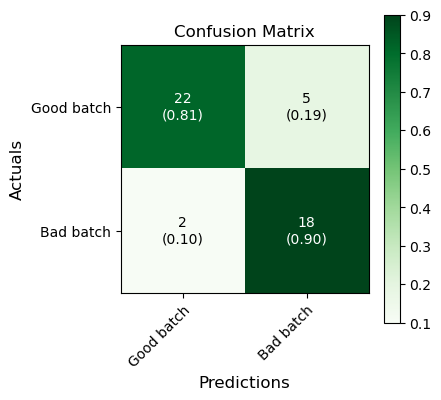

17:22:29


Training the model on 110 files:   0%|          | 0/110 [00:00<?, ?it/s]

Testing the model on 46 files:   0%|          | 0/46 [00:00<?, ?it/s]


Evaluation on Test data:
110 training files, 46 test files: TPs = 19, FPs = 7, FNs = 2, TNs = 18, ROC AUC = 0.8298076923076922
Explanation guidance accuracy = 1.0


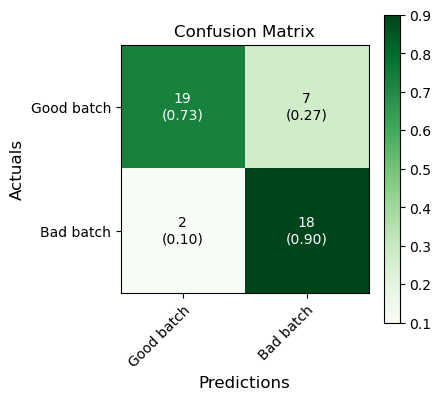

17:57:27


Training the model on 111 files:   0%|          | 0/111 [00:00<?, ?it/s]

Testing the model on 45 files:   0%|          | 0/45 [00:00<?, ?it/s]


Evaluation on Test data:
111 training files, 45 test files: TPs = 21, FPs = 5, FNs = 3, TNs = 16, ROC AUC = 0.8360323886639676
Explanation guidance accuracy = 1.0


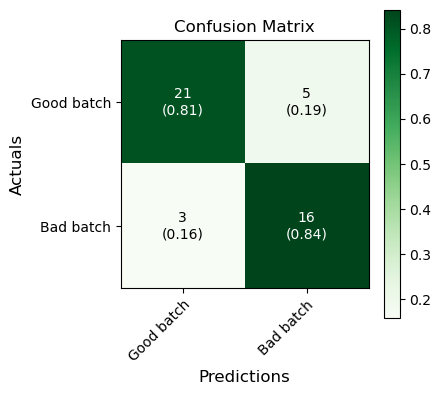

18:35:54


Training the model on 112 files:   0%|          | 0/112 [00:00<?, ?it/s]

Testing the model on 44 files:   0%|          | 0/44 [00:00<?, ?it/s]


Evaluation on Test data:
112 training files, 44 test files: TPs = 18, FPs = 7, FNs = 2, TNs = 17, ROC AUC = 0.8368421052631578
Explanation guidance accuracy = 1.0


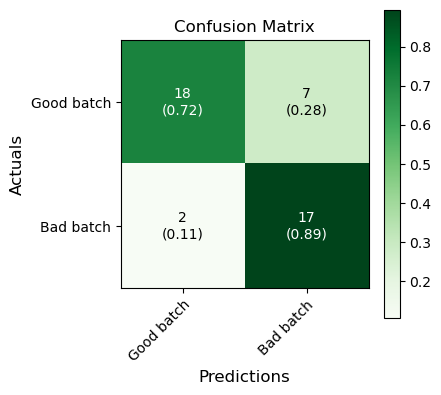

19:14:50


Training the model on 113 files:   0%|          | 0/113 [00:00<?, ?it/s]

Testing the model on 43 files:   0%|          | 0/43 [00:00<?, ?it/s]


Evaluation on Test data:
113 training files, 43 test files: TPs = 14, FPs = 11, FNs = 2, TNs = 16, ROC AUC = 0.7733333333333333
Explanation guidance accuracy = 1.0


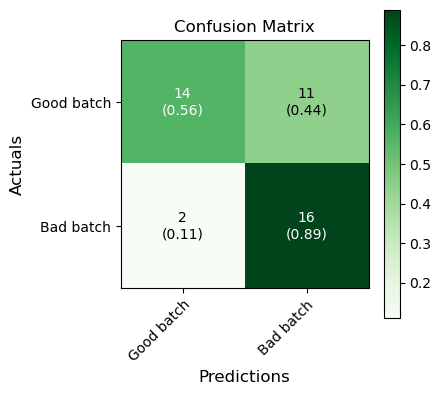

19:53:38


Training the model on 114 files:   0%|          | 0/114 [00:00<?, ?it/s]

Testing the model on 42 files:   0%|          | 0/42 [00:00<?, ?it/s]


Evaluation on Test data:
114 training files, 42 test files: TPs = 17, FPs = 7, FNs = 3, TNs = 15, ROC AUC = 0.8020833333333333
Explanation guidance accuracy = 1.0


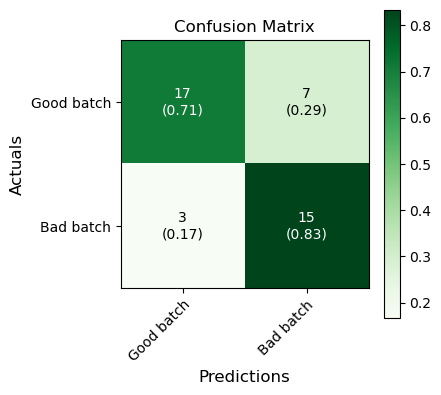

20:31:16


Training the model on 115 files:   0%|          | 0/115 [00:00<?, ?it/s]

Testing the model on 41 files:   0%|          | 0/41 [00:00<?, ?it/s]


Evaluation on Test data:
115 training files, 41 test files: TPs = 14, FPs = 9, FNs = 1, TNs = 17, ROC AUC = 0.7910628019323671
Explanation guidance accuracy = 1.0


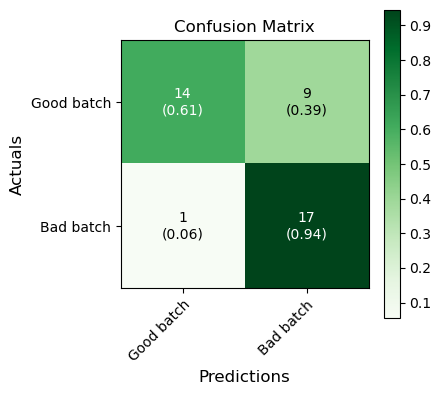

21:10:12


Training the model on 116 files:   0%|          | 0/116 [00:00<?, ?it/s]

Testing the model on 40 files:   0%|          | 0/40 [00:00<?, ?it/s]


Evaluation on Test data:
116 training files, 40 test files: TPs = 15, FPs = 7, FNs = 2, TNs = 16, ROC AUC = 0.7853535353535354
Explanation guidance accuracy = 1.0


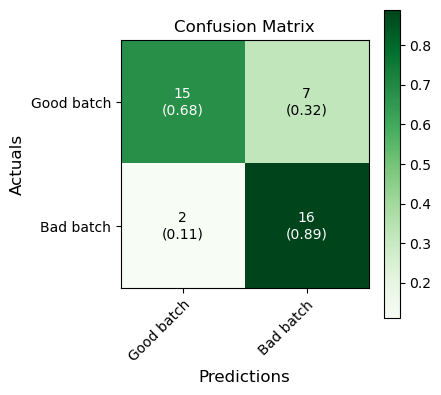

21:48:23


Training the model on 117 files:   0%|          | 0/117 [00:00<?, ?it/s]

Testing the model on 39 files:   0%|          | 0/39 [00:00<?, ?it/s]


Evaluation on Test data:
117 training files, 39 test files: TPs = 15, FPs = 6, FNs = 0, TNs = 18, ROC AUC = 0.8809523809523809
Explanation guidance accuracy = 1.0


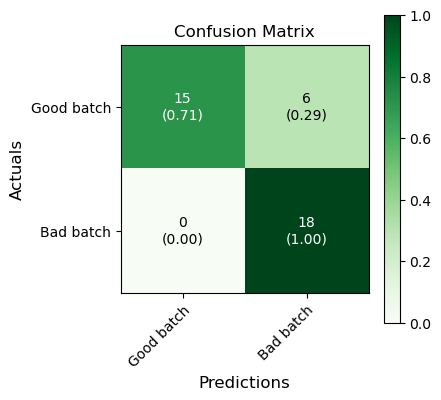

22:26:28


Training the model on 118 files:   0%|          | 0/118 [00:00<?, ?it/s]

Testing the model on 38 files:   0%|          | 0/38 [00:00<?, ?it/s]


Evaluation on Test data:
118 training files, 38 test files: TPs = 12, FPs = 9, FNs = 1, TNs = 16, ROC AUC = 0.8095238095238094
Explanation guidance accuracy = 1.0


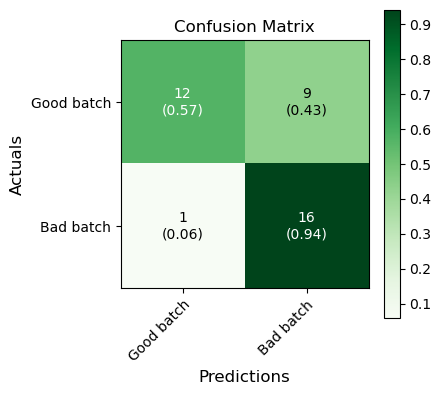

23:04:58


Training the model on 119 files:   0%|          | 0/119 [00:00<?, ?it/s]

Testing the model on 37 files:   0%|          | 0/37 [00:00<?, ?it/s]


Evaluation on Test data:
119 training files, 37 test files: TPs = 17, FPs = 3, FNs = 1, TNs = 16, ROC AUC = 0.9294117647058824
Explanation guidance accuracy = 1.0


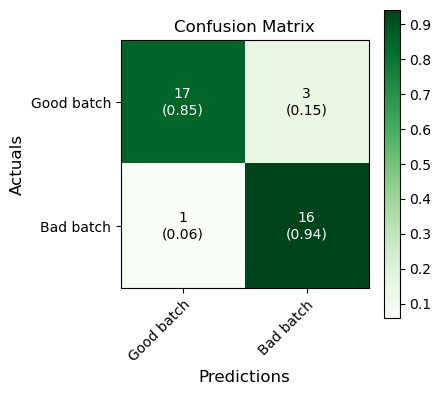

23:40:04


Training the model on 120 files:   0%|          | 0/120 [00:00<?, ?it/s]

Testing the model on 36 files:   0%|          | 0/36 [00:00<?, ?it/s]


Evaluation on Test data:
120 training files, 36 test files: TPs = 15, FPs = 4, FNs = 2, TNs = 15, ROC AUC = 0.8575851393188855
Explanation guidance accuracy = 1.0


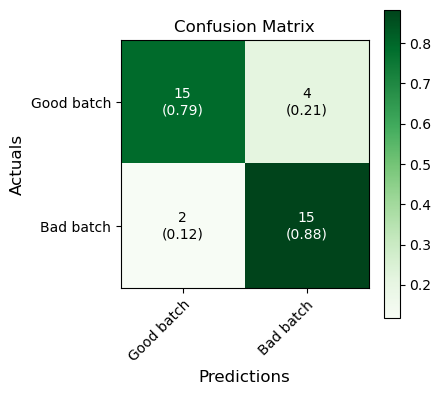

00:14:22


Training the model on 121 files:   0%|          | 0/121 [00:00<?, ?it/s]

Testing the model on 35 files:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluation on Test data:
121 training files, 35 test files: TPs = 12, FPs = 7, FNs = 2, TNs = 14, ROC AUC = 0.7598684210526316
Explanation guidance accuracy = 1.0


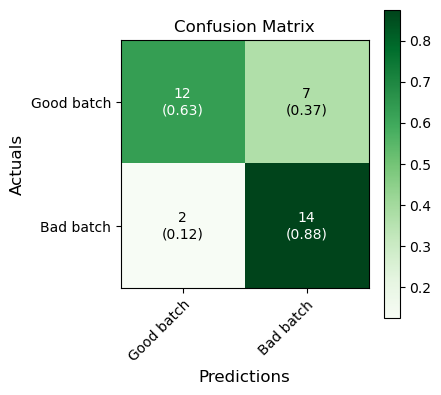

00:49:36


Training the model on 122 files:   0%|          | 0/122 [00:00<?, ?it/s]

Testing the model on 34 files:   0%|          | 0/34 [00:00<?, ?it/s]


Evaluation on Test data:
122 training files, 34 test files: TPs = 12, FPs = 7, FNs = 1, TNs = 14, ROC AUC = 0.8245614035087719
Explanation guidance accuracy = 1.0


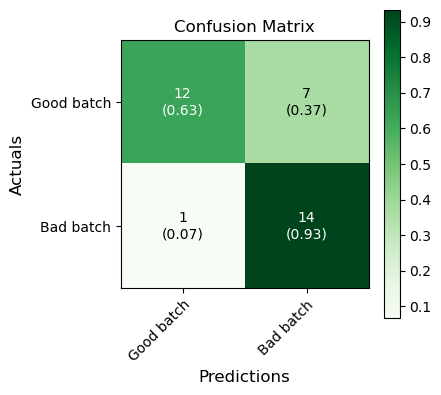

01:24:24


Training the model on 123 files:   0%|          | 0/123 [00:00<?, ?it/s]

Testing the model on 33 files:   0%|          | 0/33 [00:00<?, ?it/s]


Evaluation on Test data:
123 training files, 33 test files: TPs = 11, FPs = 8, FNs = 0, TNs = 14, ROC AUC = 0.8045112781954886
Explanation guidance accuracy = 1.0


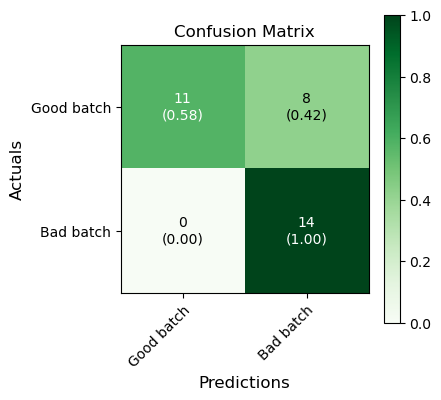

01:58:56


Training the model on 124 files:   0%|          | 0/124 [00:00<?, ?it/s]

Testing the model on 32 files:   0%|          | 0/32 [00:00<?, ?it/s]


Evaluation on Test data:
124 training files, 32 test files: TPs = 13, FPs = 5, FNs = 1, TNs = 13, ROC AUC = 0.8174603174603174
Explanation guidance accuracy = 1.0


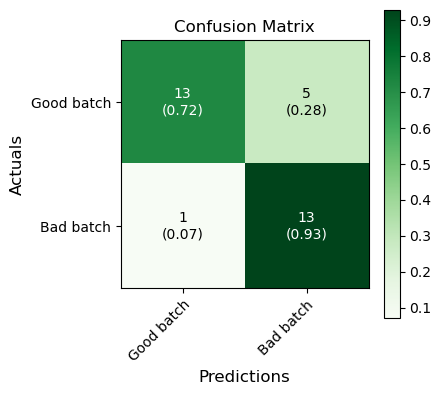

Execution time: 35032.33167743683 seconds


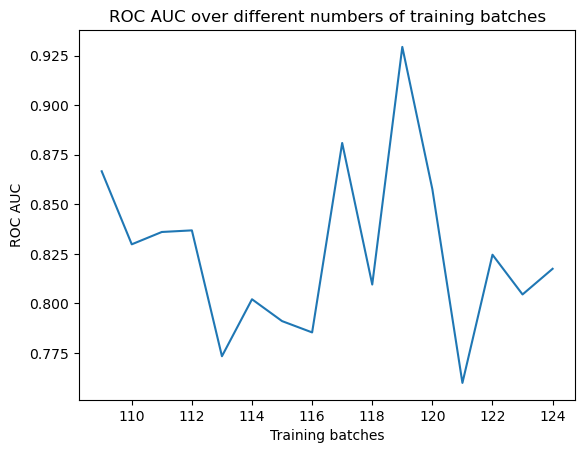

Finished


In [19]:
if __name__ == '__main__':
    main()